In [13]:
import os
import sys
import numpy as np
import time
import pygmt
import pandas as pd
import math
import matplotlib.pyplot as plt
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import RSAM
#from ASL import inventory2seedids

def inventory2seedids(inv, chancode='', force_location_code='*'):
    seed_ids = list()

    for networkObject in inv:
        if chancode:
            networkObject = networkObject.select(channel=chancode)
        stationObjects = networkObject.stations

        for stationObject in stationObjects:
            channelObjects = stationObject.channels
            for channelObject in channelObjects:
                this_seed_id = networkObject.code + '.' + stationObject.code + f'.{force_location_code}.' \
                            + channelObject.code
                seed_ids.append(this_seed_id)
    
    return seed_ids

def whakaari_map(show=False, zoom_level=0, inv=None, add_labels=False, centerlon=-62.177, \
                 centerlat=16.711, contour_interval=100, topo_color=True, plot_stations=True, plot_volcanoes=True, outfile=None):
    #define etopo data file
    # topo_data = 'path_to_local_data_file'
    #topo_data = '@earth_relief_30s' #30 arc second global relief (SRTM15+V2.1 @ 1.0 km)
    # topo_data = '@earth_relief_15s' #15 arc second global relief (SRTM15+V2.1)
    topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
    
    # define plot geographical range
    diffdeglat = 0.08/(2**zoom_level)
    diffdeglon = diffdeglat/np.cos(np.deg2rad(centerlat))
    minlon, maxlon = centerlon-diffdeglon, centerlon+diffdeglon  #-62.25, -62.13
    minlat, maxlat = centerlat-diffdeglat, centerlat+diffdeglat  # 16.66, 16.83
    region=[minlon, maxlon, minlat, maxlat]


    
    # Visualization
    fig = pygmt.Figure()
    

        
    grid = pygmt.datasets.load_earth_relief(resolution="03s", 
       region=region)

    land = grid * pygmt.grdlandmask(region=region, 
         spacing="03s", 
         maskvalues=[0, 1], 
         resolution="f")
    wet = grid * pygmt.grdlandmask(region=region, 
         spacing="03s", 
         maskvalues=[1, "NaN"], 
         resolution="f")

    # make color pallets
    '''
    pygmt.makecpt(
        cmap='topo',
        series='-1300/1300/%d' % contour_interval,
        continuous=True
    )'''

    # plot high res topography
    '''
    fig.grdimage(
        grid=topo_data,
        region=[minlon, maxlon, minlat, maxlat],
        projection='M4i',
        shading=True,
        frame=True
        )
    '''
    fig.grdimage(grid=grid, projection="M15c", cmap="geo", frame=True, shading=True)
    '''
    fig.grdimage(grid=land, projection="M15c", 
         cmap="dem1", shading=True) 
         '''
    fig.colorbar(frame=["a10", "x+lElevation", "y+lm"])
    '''
    # Plot water (NaN transparent)
    fig.grdimage(grid=wet, 
         cmap="seafloor", nan_transparent=True)
    '''
    
    # plot continents, shorelines, rivers, and borders
    '''
    fig.coast(
        region=region,
        projection='M4i',
        shorelines=True,
        frame=True
        )
    '''
    
    fig.coast(shorelines=True, projection="M15c", 
        region=region, resolution="f")
    fig.coast(rivers="1/0.5p,blue") # Rivers
    
    # plot the topographic contour lines
    '''
    fig.grdcontour(
        grid=topo_data,
        interval=contour_interval,
        #annotation="%d+f6p" % contour_interval,
        #limit="-1300/1300", #to only display it below 
        limit="0/1300"
        pen="a0.15p"
        )
    
    if topo_color:
        fig.colorbar(
            frame='+l"Topography"',
        #     position="x11.5c/6.6c+w6c+jTC+v" #for vertical colorbar
            )
            '''
    
    if inv and plot_stations:
        seed_ids = inventory2seedids(inv, force_location_code='10')
        stalat = []
        stalon = []
        for seed_id in seed_ids:
            print(seed_id)
            try:
                coords = inv.get_coordinates(seed_id)
            except:
                continue
            else:
                stalat.append(coords['latitude'])
                stalon.append(coords['longitude'])
        fig.plot(x=stalon, y=stalat, style="s0.4c", fill="dodgerblue4", pen='2p,blue')  
        
        if add_labels:
            #print('Adding station labels')
            for thislat, thislon, this_id in zip(stalat, stalon, seed_ids):
                net, sta, loc, chan = this_id.split('.')
                #print(thislat, thislon, net, sta, loc, chan)
                fig.text(x=thislon, y=thislat, text=sta, textfiles=None, \
                        font="blue",
                        justify="ML",
                        offset="0.2c/0c",)
                
    if plot_volcanoes:
        volcanoes = ['Ruapehu', 'Whakaari']
        vlats = [-39.2817, -37.5213888]
        vlons = [175.5685, 177.185]
        fig.plot(x=vlons, y=vlats, style="t0.4c", fill="red", pen='2p,red')
        if add_labels:
            for i,volcanoname in enumerate(volcanoes):
                fig.text(x=vlons[i], y=vlats[i], text=volcanoname, textfiles=None, \
                    font="red",
                    justify="ML",
                    offset="0.2c/0c",)
    if outfile:
        fig.savefig(outfile)
    if show:
        fig.show();


    return fig


inv = read_inventory(os.path.join(paths['RESPONSE_DIR'],'NZ.xml'), format='stationxml')
startt = obspy.UTCDateTime(2019,12,1)
endt = obspy.UTCDateTime(2020,12,12)
inv = inv.select(starttime=startt, endtime=endt)
inv = inv.select(channel='*Z')
inv = inv.select(channel='H*')
lat = - (37 + 31/60 + 17/3600)
lon = (177 + 11/60 + 6/3600)
source = {'lat':lat, 'lon':lon}
print(source)


{'lat': -37.521388888888886, 'lon': 177.185}


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from 172.822970043 to 172.8225
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 179.376429957 to 179.376666667
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from -41.1833 to -41.1833333333
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from -36.0633 to -36.0625
grdlandmask [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdlandmask (gmtapi_init_grdheader): Please select compatible -R and -I values
grdinfo [ERROR]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdinfo (gmtlib_read_grd_info): Use grdedit -A o

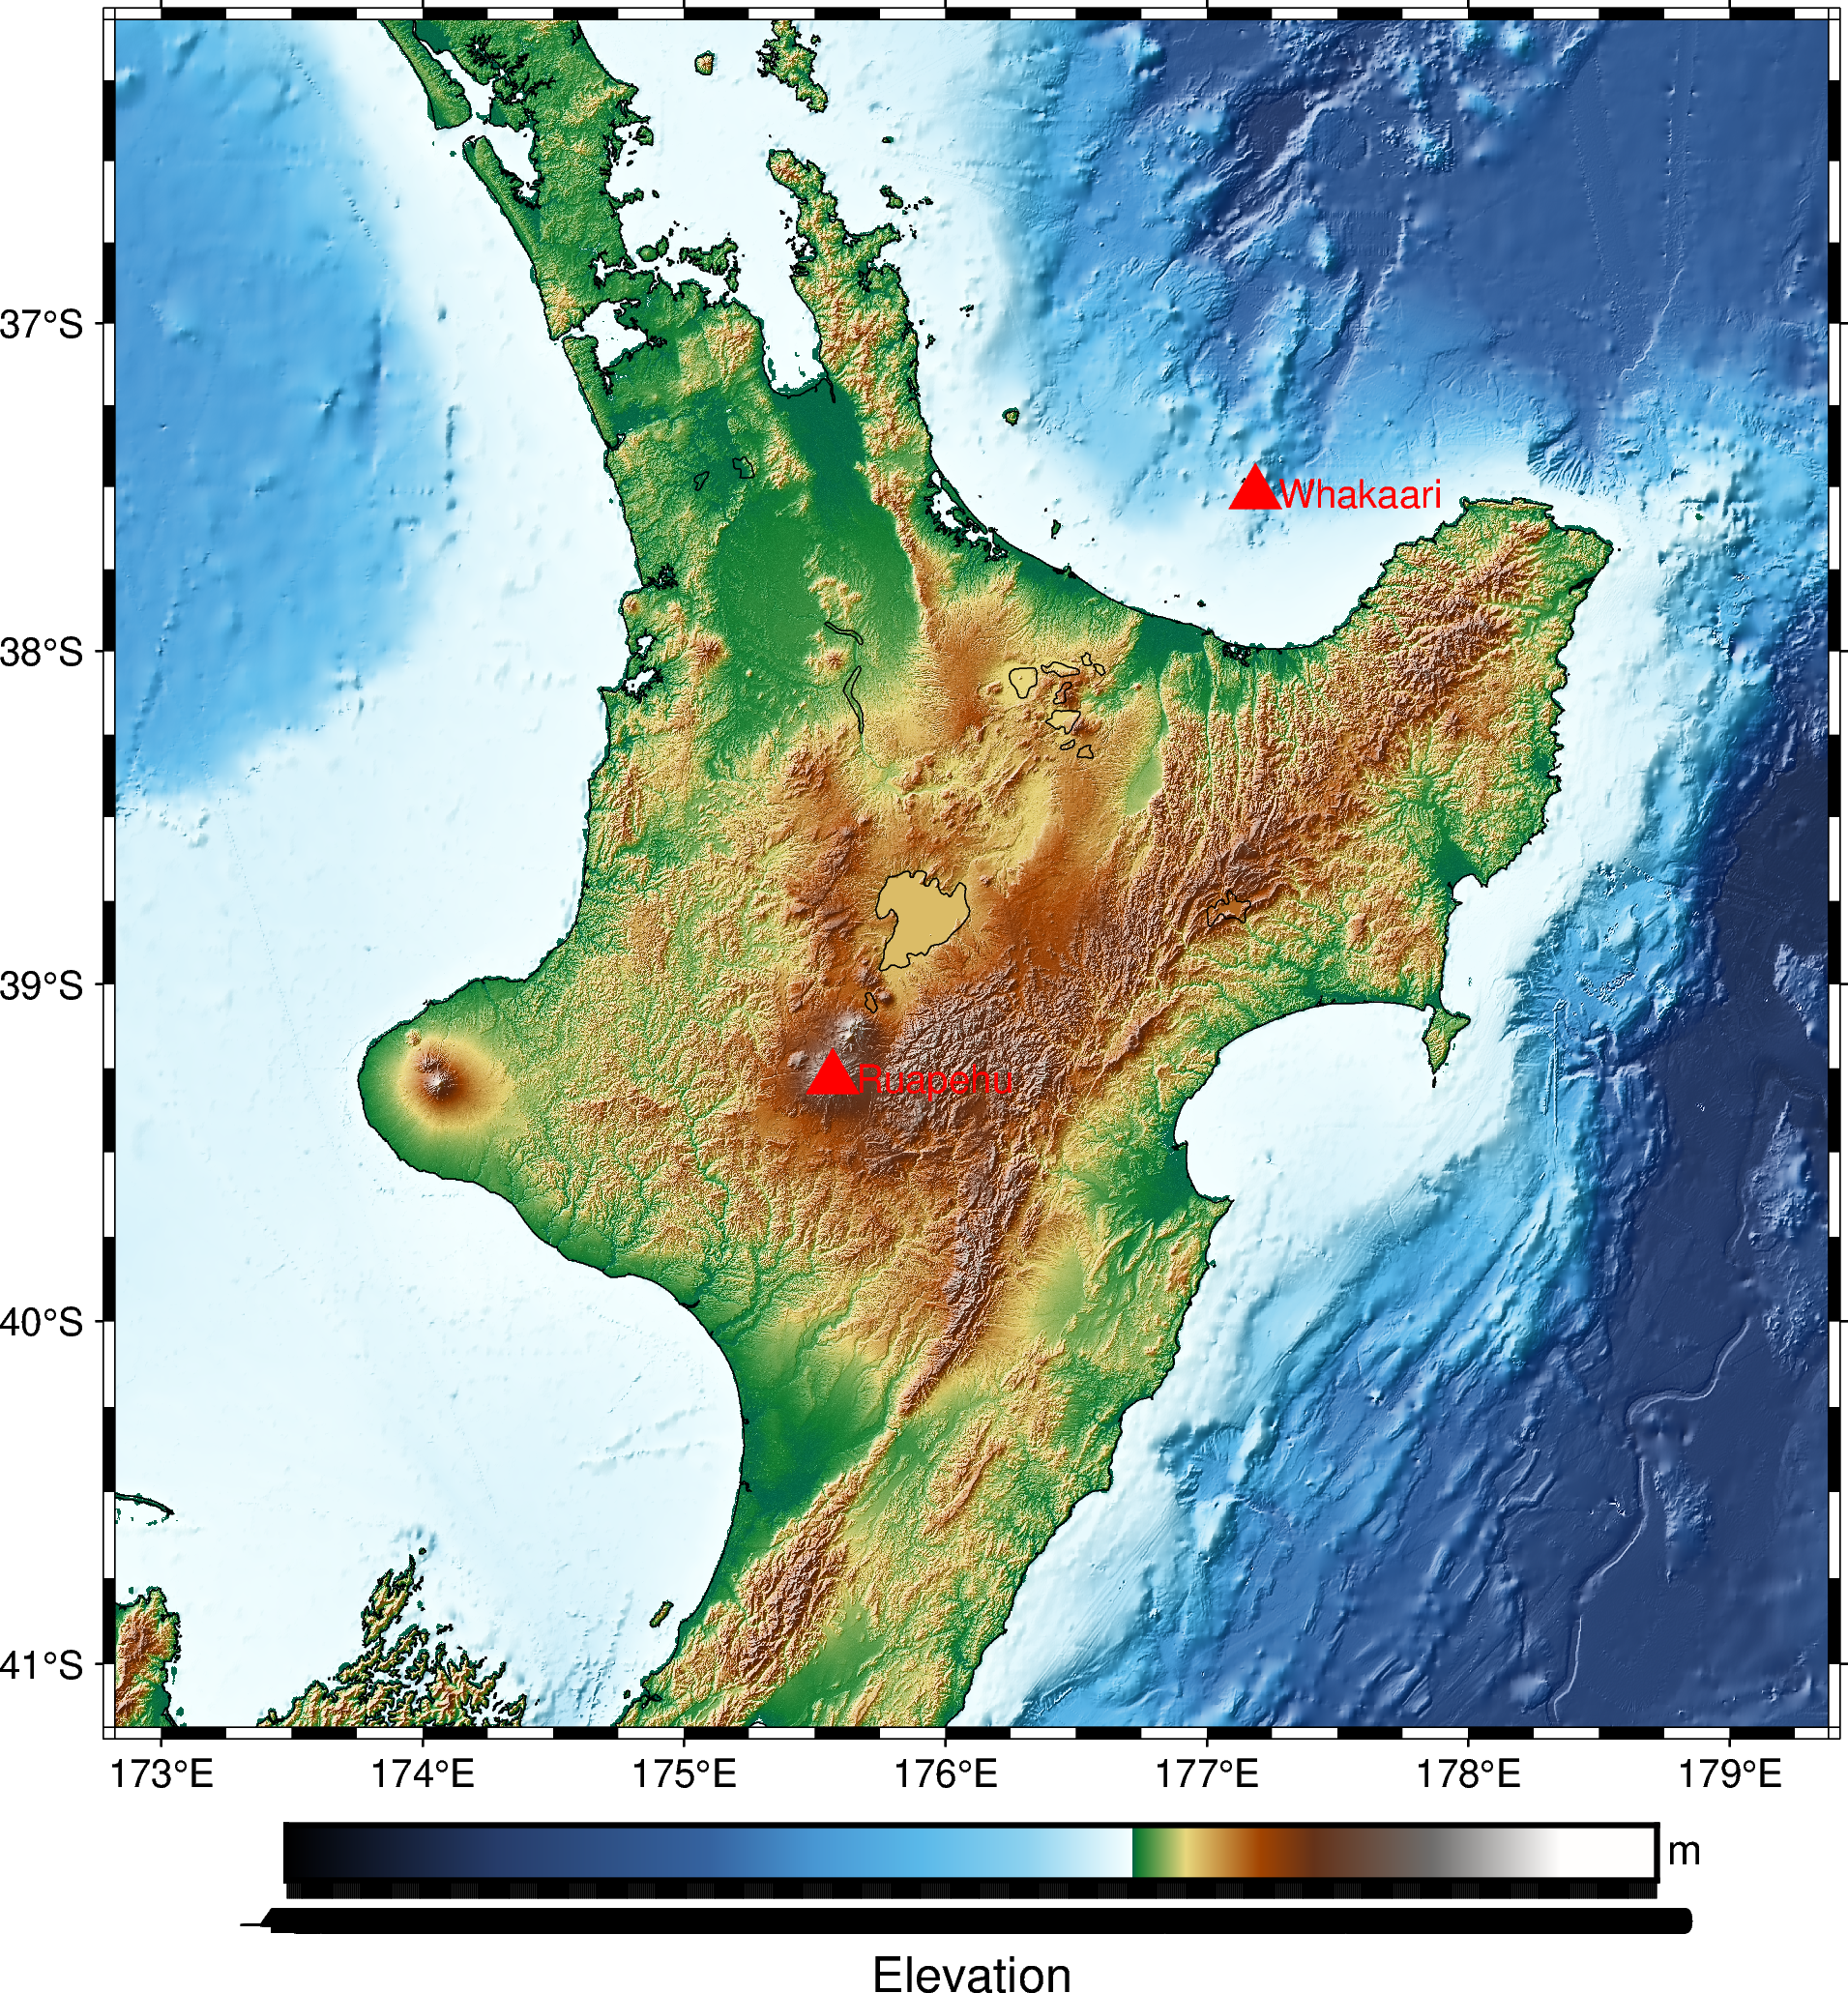

In [14]:
#whakaari_map(inv=inv, show=True, add_labels=False, centerlon=source['lon'], centerlat=source['lat'], \
#                      zoom_level=-6);
whakaari_map(inv=inv, show=True, add_labels=True, centerlon=176.0997, centerlat=-38.6233, \
                      zoom_level=-5, plot_stations=False, plot_volcanoes=True, outfile="/home/thompsong/Dropbox/BRIEFCASE/NZ_volcanoes_map.png");

In [ ]:
import os
import sys
import numpy as np
import time
import pygmt
import pandas as pd
import math
import matplotlib.pyplot as plt
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
import SAM
rsamObjList = []
secondsPerDay = 60 * 60 * 24
from obspy import UTCDateTime
eruption_times = [
    UTCDateTime(2012,8,4,16,52,0),
    UTCDateTime(2013,2,22,18,20,0),
    UTCDateTime(2013,4,5,23,59,0),
    UTCDateTime(2013,8,19,22,23,0),
    UTCDateTime(2013,10,11,7,9,0),
    UTCDateTime(2016,4,27,9,37,0),
    UTCDateTime(2019,12,9,1,11,0),
    ]
for ertime in eruption_times:
    daysbefore = 2.0 # 19.9 # 3
    stime = ertime-daysbefore * secondsPerDay
    daysafter = daysbefore/20 if daysbefore/20 < 0.1 else 0.1
    
    etime = ertime+daysafter* secondsPerDay
    try:
        rsamObj = SAM.RSAM.read(stime, etime, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle')
    except Exception as e:
        print(e)
        continue
    s = rsamObj.__size__()

    if s[1]>0:
        rsamObj = rsamObj.select(component='N')
        #rsamObj.despike(metrics='all', reps=2)
        new_sampling_interval=600
        if daysbefore>1:
            if daysbefore>10:
                rsamObj = rsamObj.downsample(new_sampling_interval=3600)
            else:
                rsamObj = rsamObj.downsample(new_sampling_interval=600)
        #rsamObj.plot(metrics=['mean', 'median', 'rms', 'max', 'VLP', 'LP', 'VT', 'fratio'], equal_scale=True)
        #rsamObj.plot(metrics=['median', 'fratio'], equal_scale=True)
        #rsamObj.plot(kind='line', metrics='bands')
        fh, axh1=plt.subplots(1,1)
        fh.set_size_inches(10, 2)
        DF = rsamObj.dataframes['NZ.WSRZ.10.HHN']
        axh1.plot(DF['median'], 'C0')
        if new_sampling_interval:
            if new_sampling_interval==600:
                axh1.set_ylabel('RSAM\nmedian of 10-min window', color='C0')
            elif new_sampling_interval==3600:
                axh1.set_ylabel('RSAM\nmedian of each 1-hr window', color='C0')
        else:
            axh1.set_ylabel('RSAM\nmedian of each 1-min window', color='C0')
        axh1.tick_params(axis='y', color='C0', labelcolor='C0')
        axh2 = axh1.twinx()
        axh2.plot(DF['fratio'], 'C1')
        axh2.set_ylabel('Frequency Ratio\nlog2(VT band/LP band)', color='C1')
        axh2.tick_params(axis='y', color='C1', labelcolor='C1')
        axh2.spines['right'].set_color('C1')
        axh2.spines['left'].set_color('C0')
        for tick in axh1.get_xticklabels():
            tick.set_rotation(90)
        plt.show()
        
    #rsamObjList.append(rsamObj)
#rsamObj10min.plot(kind='line', metrics='bands')

In [ ]:
import os
import sys
import numpy as np
import time
import pygmt
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as md
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
import SAM
rsamObjList = []
secondsPerDay = 60 * 60 * 24
from obspy import UTCDateTime
eruption_times = [
    UTCDateTime(2012,8,4,16,52,0),
    UTCDateTime(2013,2,22,18,20,0),
    UTCDateTime(2013,4,5,23,59,0),
    UTCDateTime(2013,8,19,22,23,0),
    UTCDateTime(2013,10,11,7,9,0),
    UTCDateTime(2016,4,27,9,37,0),
    UTCDateTime(2019,12,9,1,11,0),
    ]
for ertime in eruption_times:
    daysbefore = 1.5 # 19.9 # 3
    stime = ertime-daysbefore * secondsPerDay
    daysafter = daysbefore/20 if daysbefore/20 < 0.1 else 0.1
    daysafter = 0
    
    etime = ertime+daysafter* secondsPerDay
    try:
        rsamObj = SAM.RSAM.read(stime, etime, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle')
    except Exception as e:
        print(e)
        continue
    s = rsamObj.__size__()

    if s[1]>0:
        rsamObj = rsamObj.select(component='N')
        #rsamObj.despike(metrics='all', reps=2)
        rsamObj = rsamObj.downsample(new_sampling_interval=3600)
        '''
        if daysbefore>1:
            if daysbefore>10:
                rsamObj = rsamObj.downsample(new_sampling_interval=3600)
            else:
                rsamObj = rsamObj.downsample(new_sampling_interval=600)
                '''
        #rsamObj.plot(metrics=['mean', 'median', 'rms', 'max', 'VLP', 'LP', 'VT', 'fratio'], equal_scale=True)
        #rsamObj.plot(metrics=['median', 'fratio'], equal_scale=True)
        #rsamObj.plot(kind='line', metrics='bands')
        fh, axh1=plt.subplots(1,1)
        fh.set_size_inches(10, 2)
        DF = rsamObj.dataframes['NZ.WSRZ.10.HHN']
        axh1.plot(DF['median'], 'C0')
        if new_sampling_interval:
            if new_sampling_interval==600:
                axh1.set_ylabel('RSAM\nmedian of 10-min window', color='C0')
            elif new_sampling_interval==3600:
                axh1.set_ylabel('RSAM\nmedian of each 1-hr window', color='C0')
        else:
            axh1.set_ylabel('RSAM\nmedian of each 1-min window', color='C0')
        axh1.tick_params(axis='y', color='C0', labelcolor='C0')
        axh2 = axh1.twinx()
        axh2.plot(DF['fratio'], 'C1')
        axh2.grid()
        axh2.set_ylabel('Frequency Ratio\nlog2(VT band/LP band)', color='C1')
        axh2.tick_params(axis='y', color='C1', labelcolor='C1')
        axh2.spines['right'].set_color('C1')
        axh2.spines['left'].set_color('C0')
        axh1.xaxis.set_major_locator(md.MinuteLocator(byminute = [0]))
        axh1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
        plt.setp(axh1.xaxis.get_majorticklabels(), rotation = 90)
        for tick in axh1.get_xticklabels():
            tick.set_rotation(90)
        plt.show()
        
    #rsamObjList.append(rsamObj)
#rsamObj10min.plot(kind='line', metrics='bands')

In [ ]:
region = whakaari_map(inv=inv, show=True, add_labels=True, centerlon=source['lon'], centerlat=source['lat'], zoom_level=-5);
#whakaari_map(inv=inv, show=True, add_labels=True, centerlon=source['lon'], centerlat=source['lat'], zoom_level=3);
grid = pygmt.datasets.load_earth_relief(resolution="03s", 
       region=region)
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="M15c", cmap="geo")
fig.colorbar(frame=["a10", "x+lElevation", "y+lm"])
fig.coast(shorelines=True, region=region, resolution="f")
fig.show()

In [ ]:
t = [obspy.UTCDateTime(this_time) for this_time in rsamObj.dataframes['NZ.WIZ.10.HHZ'].time]

In [ ]:
rsamObj.plot(metrics='bands')

In [ ]:
import obspy
import SDS
sds_stime=obspy.UTCDateTime(2019,11,18)
from obspy.clients.filesystem.sds import Client as sdsclient
rawSDSclient = SDS.SDSobj(paths['SDS_VEL_DIR'], sds_type='D', format='MSEED')
rawSDSclient.read(sds_stime, sds_stime+86400/2)
st = rawSDSclient.stream

In [ ]:
st=st.select(location='10')
st = st.select(component='Z')
st.plot(equal_scale=False);

In [ ]:
# Plot eruption waveforms, and maybe compute 1-s SAM metrics


# start by defining eruption time windows

# loop over eruption time windows, and plot. might want to do full sequence here, so not tied into my coninuous data pipeline
# so start with retrieving inventory and then raw data, and then correct raw data

# turn this into an example for MESS
